## Exploring the Dataset

### Importing all the necessary libraries

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

### Data Loading

In [4]:
reviews = pd.read_json('data\Yelp-JSON\Yelp JSON\Extracted\yelp_academic_dataset_review.json', lines=True, nrows=500000)
print(reviews.shape)
reviews.head()

(500000, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [6]:
reviews.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
stars,500000.0,3.806634,1.0,3.0,4.0,5.0,5.0,1.418262
useful,500000.0,1.02857,0.0,0.0,0.0,1.0,320.0,2.409103
funny,500000.0,0.285922,0.0,0.0,0.0,0.0,284.0,1.245599
cool,500000.0,0.410568,0.0,0.0,0.0,0.0,164.0,1.437532
date,500000,2016-03-16 20:53:34.274245632,2005-03-01 17:47:15,2014-06-02 02:55:32.249999872,2016-07-15 04:08:53,2018-05-27 16:23:37.500000,2022-01-19 00:51:23,NaN


In [7]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   review_id    500000 non-null  object        
 1   user_id      500000 non-null  object        
 2   business_id  500000 non-null  object        
 3   stars        500000 non-null  int64         
 4   useful       500000 non-null  int64         
 5   funny        500000 non-null  int64         
 6   cool         500000 non-null  int64         
 7   text         500000 non-null  object        
 8   date         500000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 34.3+ MB


In [10]:
reviews['length'] = reviews['text'].apply(lambda x: len(x.split()))

reviews['date'] = pd.to_datetime(reviews['date'])
reviews['year'] = reviews['date'].dt.year
reviews['month'] = reviews['date'].dt.month 
reviews['day'] = reviews['date'].dt.day

reviews.drop(columns=['date'], inplace=True)

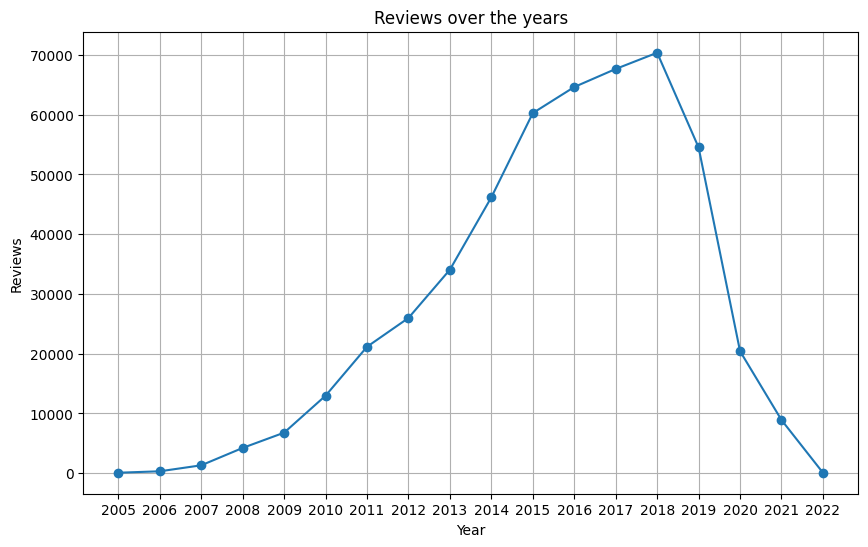

In [11]:
reviews_per_year = reviews.groupby('year').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.plot(reviews_per_year['year'], reviews_per_year['count'], marker='o', linestyle='-')
plt.title('Reviews over the years')
plt.xlabel('Year')
plt.ylabel('Reviews')
plt.xticks(reviews_per_year['year'])
plt.grid()
plt.show()

In [12]:
reviews = reviews[(reviews['year'] >= 2008) & (reviews['year'] <= 2017)]

reviews = reviews[reviews['length'] >= 10]

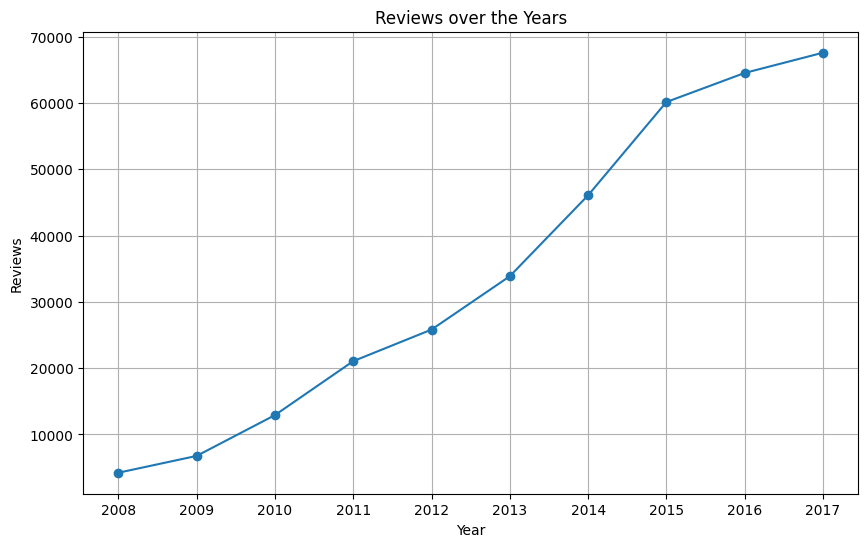

In [13]:
# time series analysis - reviews per year
reviews_per_year = reviews.groupby('year').size().reset_index(name='count')

# plotting
plt.figure(figsize=(10, 6))
plt.plot(reviews_per_year['year'], reviews_per_year['count'], marker='o', linestyle='-')
plt.title('Reviews over the Years')
plt.xlabel('Year')
plt.ylabel('Reviews')
plt.xticks(reviews_per_year['year'])
plt.grid()
plt.show()

### Creating Binary Sentiment Labels

In [18]:
reviews['sentiment'] = reviews['stars'].apply(lambda x: 1 if x >= 4 else 0)
reviews['sentiment'].value_counts()

texts = reviews['text'].values
labels = reviews['sentiment'].values

### Train test splitting

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    padded, labels, test_size=0.2, stratify=labels, random_state=42
)

### Text tokenization

In [21]:
X_train = X_train.astype(str).tolist()
X_test = X_test.astype(str).tolist()

# Tokenization
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 300

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert to sequences
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_SEQUENCE_LENGTH)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

Found 20001 unique tokens.


### Loading GloVe Embeddings

In [22]:
glove_path = 'embeddings/glove.6B.100d.txt'

EMBEDDING_DIM = 100
embeddings_index = {}

with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors in GloVe.")

# Prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 400001 word vectors in GloVe.


### Build Keras GRU with GloVe

In [24]:
model = Sequential([
    Embedding(
        input_dim=num_words,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False
    ),
    GRU(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          2000000   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2096641 (8.00 MB)
Trainable params: 9664

### Train the model

In [26]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    callbacks=[early_stop]
)

Epoch 1/10


1716/1716 [==============================] - 557s 323ms/step - loss: 0.5897 - accuracy: 0.6985 - val_loss: 0.4547 - val_accuracy: 0.7879
Epoch 2/10
1716/1716 [==============================] - 569s 332ms/step - loss: 0.4090 - accuracy: 0.8178 - val_loss: 0.3401 - val_accuracy: 0.8517
Epoch 3/10
1716/1716 [==============================] - 566s 330ms/step - loss: 0.3379 - accuracy: 0.8577 - val_loss: 0.3116 - val_accuracy: 0.8675
Epoch 4/10
1716/1716 [==============================] - 556s 324ms/step - loss: 0.3087 - accuracy: 0.8719 - val_loss: 0.2991 - val_accuracy: 0.8744
Epoch 5/10
1716/1716 [==============================] - 550s 320ms/step - loss: 0.2867 - accuracy: 0.8830 - val_loss: 0.3208 - val_accuracy: 0.8600
Epoch 6/10
1716/1716 [==============================] - 558s 325ms/step - loss: 0.2716 - accuracy: 0.8898 - val_loss: 0.2949 - val_accuracy: 0.8785
Epoch 7/10
1716/1716 [==============================] - 556s 324ms/step - loss: 0.2597 - accuracy: 0.8952 - va

### Evaluvation

### Testing Accuracy

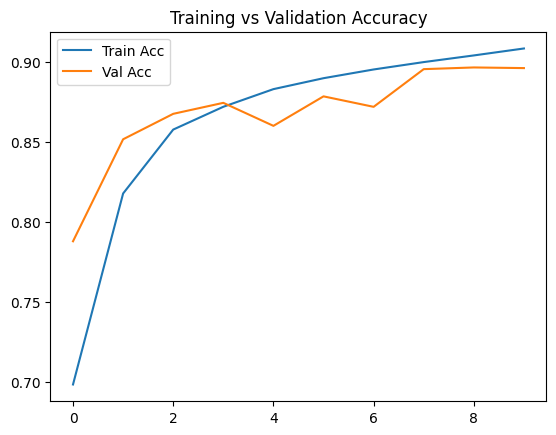

2144/2144 [==============================] - 72s 34ms/step - loss: 0.2621 - accuracy: 0.8952
Test Accuracy: 0.8952


In [27]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

# Final evaluation
loss, accuracy = model.evaluate(X_test_seq, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

#### F1 Score

In [28]:
y_pred_probs = model.predict(X_test_seq)
y_pred = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=4))


2144/2144 [==============================] - 76s 35ms/step
              precision    recall  f1-score   support

           0     0.8728    0.7847    0.8264     21809
           1     0.9042    0.9467    0.9249     46796

    accuracy                         0.8952     68605
   macro avg     0.8885    0.8657    0.8757     68605
weighted avg     0.8942    0.8952    0.8936     68605



#### Confusion Matrics

2144/2144 [==============================] - 72s 34ms/step


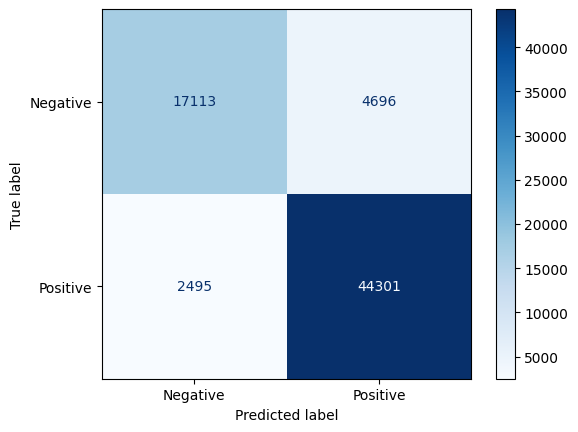

In [ ]:
y_pred_prob = model.predict(X_test_seq)
y_pred = (y_pred_prob > 0.5).astype("int32")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')

#### Classification Report

In [30]:
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.87      0.78      0.83     21809
    Positive       0.90      0.95      0.92     46796

    accuracy                           0.90     68605
   macro avg       0.89      0.87      0.88     68605
weighted avg       0.89      0.90      0.89     68605

